In [6]:
pip install pandas geopandas scipy shapely matplotlib seaborn esda scikit-learn contextily pysal numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.12/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import esda 
from shapely.geometry import box
from pysal.lib import weights
from splot.esda import moran_scatterplot,lisa_cluster
from sklearn.linear_model import LinearRegression

In [8]:
dfTasse=pd.read_csv("Dataset/TasseAmbientali.csv")
dfEmissioni=pd.read_csv("Dataset/EmissioniTotali.csv")
dfTasseCF= pd.read_csv("Dataset/TassePC.csv")
gdfNazioni=gpd.read_file("Dataset/CNTR_RG_60M_2024_4326.gpkg")
dfImprese=pd.read_csv("Dataset/Imprese.csv")
dfImprese2=pd.read_csv("Dataset/Imprese.csv")
dfTassePercent=pd.read_csv("Dataset/TassePercentuale.csv")
dfEmissioniEuropa=pd.read_csv("Dataset/EmissioniEuropee.csv")
dfPilProCap=pd.read_csv("Dataset/PilProCap.csv")

In [9]:
dfEmissioniEuropa

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,airpol,Air pollutants and greenhouse gases,src_nfr,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,AS,Arsenic (As),NFR11A,...,EU27_2020,European Union - 27 countries (from 2020),1995,NaN,0,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,AS,Arsenic (As),NFR11A,...,EU27_2020,European Union - 27 countries (from 2020),1996,NaN,0,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,AS,Arsenic (As),NFR11A,...,EU27_2020,European Union - 27 countries (from 2020),1997,NaN,0,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,AS,Arsenic (As),NFR11A,...,EU27_2020,European Union - 27 countries (from 2020),1998,NaN,0,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,AS,Arsenic (As),NFR11A,...,EU27_2020,European Union - 27 countries (from 2020),1999,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40864,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,ZN,Zinc (Zn),NFR_TOT_NAT_C,...,EU27_2020,European Union - 27 countries (from 2020),2018,NaN,4179,NaN,NaN,NaN,NaN,NaN
40865,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,ZN,Zinc (Zn),NFR_TOT_NAT_C,...,EU27_2020,European Union - 27 countries (from 2020),2019,NaN,3910,NaN,NaN,NaN,NaN,NaN
40866,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,ZN,Zinc (Zn),NFR_TOT_NAT_C,...,EU27_2020,European Union - 27 countries (from 2020),2020,NaN,3540,NaN,NaN,NaN,NaN,NaN
40867,dataflow,ESTAT:ENV_AIR_EMIS(1.0),Air pollutants by source sector,A,Annual,T,Tonne,ZN,Zinc (Zn),NFR_TOT_NAT_C,...,EU27_2020,European Union - 27 countries (from 2020),2021,NaN,3743,NaN,NaN,NaN,NaN,NaN


In [10]:
dfTasse["OBS_FLAG"]=dfTasse["OBS_FLAG"].fillna(0)
dfTasse=dfTasse[dfTasse["OBS_FLAG"]==0]
dfTasse.drop(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency','Geopolitical entity (reporting)','TIME_PERIOD', 'Time','Observation value', 'OBS_FLAG',
       'Observation status (Flag) V2 structure', 'CONF_STATUS',
       'Confidentiality status (flag)'],axis=1,inplace=True)
dfTasse=dfTasse[dfTasse['tax']!="TRA"]

In [11]:
dfTasseABS=dfTasse[dfTasse["unit"]=="MIO_EUR"]
dfTassePC=dfTasse[dfTasse["unit"]=="PC_GDP"]

In [12]:
dfTasseABS=dfTasseABS.groupby("geo").aggregate({"OBS_VALUE":"mean"})
dfTasseABS=dfTasseABS.rename(columns={"OBS_VALUE":"MilioniE"})

In [13]:
dfTassePC=dfTassePC.groupby("geo").aggregate({"OBS_VALUE":"mean"})
dfTassePC=dfTassePC.rename(columns={"OBS_VALUE":"PC_GDP"})

<Axes: xlabel='geo', ylabel='PC_GDP'>

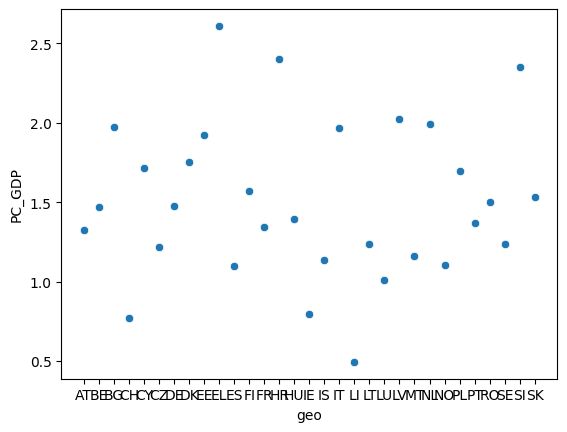

In [14]:
sns.scatterplot(x="geo",y="PC_GDP",data=dfTassePC)

In [15]:
dfEmissioni.columns

Index(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
       'airpol', 'Air pollutants and greenhouse gases', 'indic_env',
       'Environment indicator', 'unit', 'Unit of measure', 'geo',
       'Geopolitical entity (reporting)', 'TIME_PERIOD', 'Time', 'OBS_VALUE',
       'Observation value', 'OBS_FLAG',
       'Observation status (Flag) V2 structure', 'CONF_STATUS',
       'Confidentiality status (flag)'],
      dtype='object')

In [16]:
dfEmissioni["OBS_FLAG"]=dfEmissioni["OBS_FLAG"].fillna(0)
dfEmissioni=dfEmissioni[dfEmissioni["OBS_FLAG"]==0]
dfEmissioniTempoT=dfEmissioni[dfEmissioni["unit"]=='T']
dfEmissioniTempoProCap=dfEmissioni[dfEmissioni['unit']=='KG_HAB']
dfEmissioniTempoProCap=dfEmissioni.groupby('TIME_PERIOD').aggregate({"OBS_VALUE":"mean"})
dfEmissioniTempoT=dfEmissioni.groupby('TIME_PERIOD').aggregate({"OBS_VALUE":"mean"})
dfEmissioniTempoT=dfEmissioniTempoT.rename(columns={"OBS_VALUE":"Emissioni"})
dfEmissioniTempoProCap=dfEmissioniTempoProCap.rename(columns={"OBS_VALUE":"Emissioni"})

dfEmissioniTempoT.to_pickle("EmissioniTempoT.pickle")
dfEmissioniTempoProCap.to_pickle("EmissioniTempoProCap.pickle")
dfEmissioni.drop(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
       'airpol', 'Air pollutants and greenhouse gases', 'indic_env',
       'Environment indicator', 'Unit of measure',
       'Geopolitical entity (reporting)', 'TIME_PERIOD', 'Time',
       'Observation value', 'OBS_FLAG',
       'Observation status (Flag) V2 structure', 'CONF_STATUS',
       'Confidentiality status (flag)'], axis=1, inplace=True )

In [17]:
dfEmissioniProCap=dfEmissioni[dfEmissioni['unit']=='KG_HAB']
dfEmissioniT=dfEmissioni[dfEmissioni['unit']=='T']

In [18]:
dfEmissioniProCap=dfEmissioniProCap.groupby("geo").aggregate({"OBS_VALUE":"mean"})
dfEmissioniProCap=dfEmissioniProCap.rename(columns={"OBS_VALUE":"EmissioniProCap"})

In [19]:
dfEmissioniT=dfEmissioniT.groupby("geo").aggregate({"OBS_VALUE":"mean"})
dfEmissioniT=dfEmissioniT.rename(columns={"OBS_VALUE":"T"})

<Axes: xlabel='geo', ylabel='EmissioniProCap'>

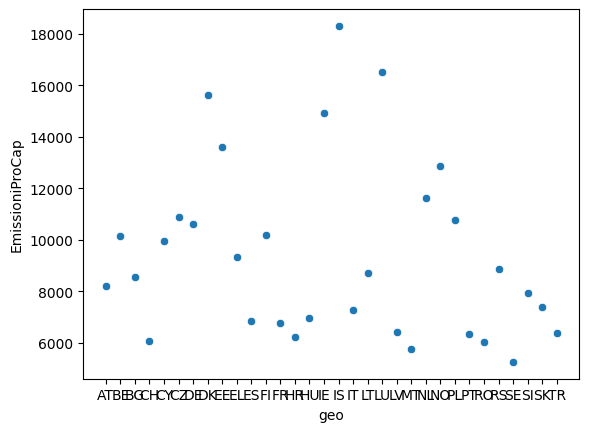

In [20]:
dfEmissioniT.to_pickle("EmissioniTGEO.pickle")
dfEmissioniProCap.to_pickle("EmissioniProCapGEO.pickle")
sns.scatterplot(x="geo",y="EmissioniProCap",data=dfEmissioniProCap)

In [21]:
dfTotali=dfEmissioniT.merge(dfTasseABS,on="geo")
dfProCap=dfEmissioniProCap.merge(dfTassePC,on="geo")

In [22]:
correlazione1=sp.stats.pearsonr(dfTotali["T"],dfTotali["MilioniE"])
correlazione1

PearsonRResult(statistic=0.9433264133958338, pvalue=6.095616879119124e-15)

In [23]:
correlazione2=sp.stats.pearsonr(dfProCap["EmissioniProCap"],dfProCap["PC_GDP"])
correlazione2

PearsonRResult(statistic=-0.16373494271493322, pvalue=0.3872790357149258)

In [24]:
dfTasseCF.drop(['energia_ammontare','paese', 'di_cui_carburanti_per_autotrazione_ammontare',
       'di_cui_carburanti_per_autotrazione_ranking'], axis=1, inplace=True)

In [25]:
dfTotali2=dfTasseCF.merge(dfEmissioniProCap, on="geo")

In [26]:
correlazione3=sp.stats.pearsonr(dfTotali2["energia_percent_su_tassazione_totale"]-dfTotali2["di_cui_carburanti_per_autotrazione_percent_su_tassazione_totale"],dfTotali2["EmissioniProCap"])
correlazione3

PearsonRResult(statistic=-0.06910969646246719, pvalue=0.7319580342146438)

In [27]:
gdfNazioni=gdfNazioni[gdfNazioni["EU_STAT"]=='T']

In [28]:
gdfNazioni.drop([ 'CNTR_NAME', 'NAME_ENGL', 'NAME_FREN', 'ISO3_CODE',
       'SVRG_UN', 'CAPT', 'EU_STAT', 'EFTA_STAT', 'CC_STAT', 'NAME_GERM'],axis=1,inplace=True)

In [29]:
gdfNazioni.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

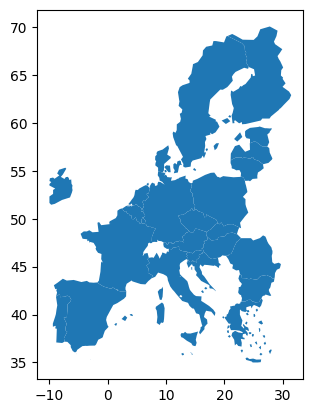

In [30]:
mask = gpd.GeoSeries([box(-10, 35, 32, 72)], crs="EPSG:4326")
gdfNazioni = gdfNazioni[gdfNazioni.intersects(mask.iloc[0])].copy()
gdfNazioni["geometry"] = gdfNazioni.geometry.intersection(mask.iloc[0])
gdfNazioni.plot()

In [31]:
gdfNazioni.columns

Index(['CNTR_ID', 'geometry'], dtype='object')

In [32]:
gdfNazioniEmissioniT=gpd.GeoDataFrame(
    dfEmissioniT.merge(gdfNazioni,left_on="geo",right_on="CNTR_ID"),
    geometry="geometry",
    crs=gdfNazioni.crs
)

<Axes: >

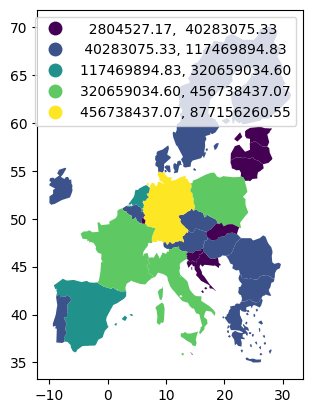

In [33]:
gdfNazioniEmissioniT.plot(column="T",scheme="fisher_jenks",k=5, legend=True)

('WARNING: ', -0.37092390862785507, ' is an island (no neighbors)')
('WARNING: ', -0.7220723257747261, ' is an island (no neighbors)')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: -0.37092390862785507, -0.7220723257747261.
  W.__init__(self, neighbors, ids=ids, **kw)


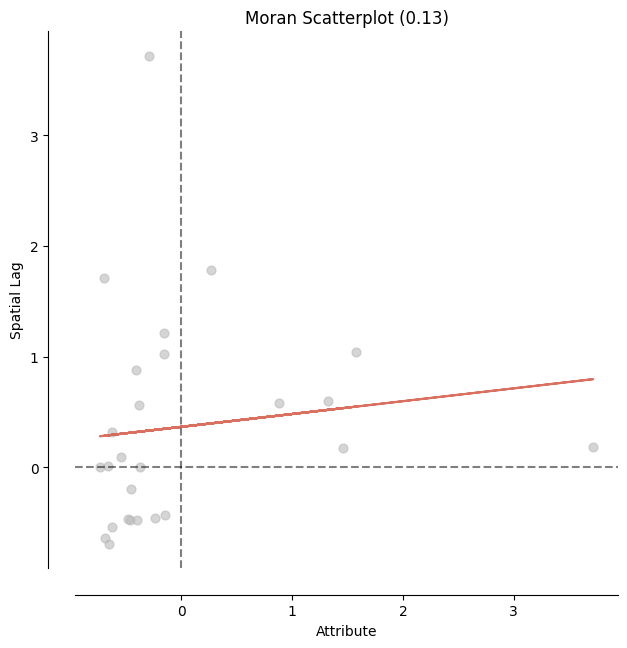

In [39]:
gdfNazioniEmissioniT['T_STD']=(gdfNazioniEmissioniT['T']-gdfNazioniEmissioniT['T'].mean())/gdfNazioniEmissioniT['T'].std()
W=weights.Queen.from_dataframe(gdfNazioniEmissioniT,ids="T_STD")
Moran=esda.Moran(gdfNazioniEmissioniT["T_STD"],W)
moran_scatterplot(Moran);

In [40]:
Moran.I

0.12541611817283865

In [41]:
Lisa=esda.Moran_Local(gdfNazioniEmissioniT["T"],W)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/esda/moran.py:1351: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


(<Figure size 640x480 with 1 Axes>, <Axes: >)

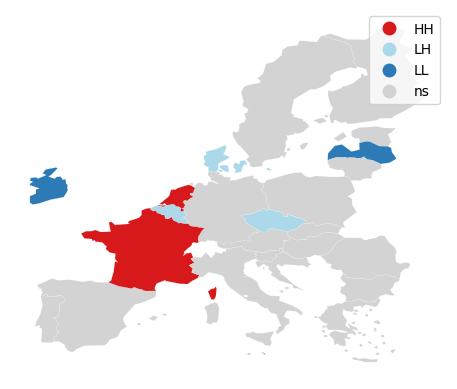

In [42]:
lisa_cluster(Lisa,gdfNazioniEmissioniT)

In [43]:
gdfNazioniEmissioniT["Area"]=gdfNazioniEmissioniT.to_crs(epsg=32632).area / 10**6

In [44]:
gdfNazioniEmissioniT

,T,CNTR_ID,geometry,T_STD,Area
0,7.232905e+07,AT,"POLYGON ((16.94978 48.53579, 16.85104 48.43864...",-0.374736,84300.491375
1,1.157979e+08,BE,"POLYGON ((5.79827 51.05985, 5.76607 51.00859, ...",-0.157570,30365.121427
2,5.775631e+07,BG,"POLYGON ((24.32352 43.69769, 24.49383 43.76107...",-0.447539,116408.582534
3,1.154959e+08,CZ,"POLYGON ((14.6188 50.8578, 14.82336 50.87055, ...",-0.159079,81019.452902
4,8.771563e+08,DE,"MULTIPOLYGON (((9.40281 54.80694, 9.42293 54.8...",3.646091,354078.998336
5,9.033952e+07,DK,"MULTIPOLYGON (((15.04086 54.98545, 14.63852 55...",-0.284757,41216.160704
6,1.802596e+07,EE,"MULTIPOLYGON (((26.9611 59.43595, 27.17245 59....",-0.646028,46621.318276
7,1.000838e+08,EL,"MULTIPOLYGON (((27.83164 35.87551, 27.61189 36...",-0.236076,135861.997674
8,3.206590e+08,ES,"MULTIPOLYGON (((4.20006 39.83676, 3.8399 39.92...",0.865893,513240.013860
9,5.611255e+07,FI,"MULTIPOLYGON (((28.49493 68.46963, 28.69363 68...",-0.455751,348531.170812


In [45]:
dfImprese.drop(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
       'age', 'Age class', 'sizeclas', 'Size classes in number of employees',
       'indic_sbs', 'Economic indicator for structural business statistics',
       'nace_r2',
       'Statistical classification of economic activities in the European Community (NACE Rev. 2)','Geopolitical entity (reporting)', 'TIME_PERIOD', 'Time', 'Observation value', 'OBS_FLAG',
       'Observation status (Flag) V2 structure', 'CONF_STATUS',
       'Confidentiality status (flag)'],axis=1, inplace=True)

In [46]:
dfImprese=dfImprese.rename(columns={"OBS_VALUE":"I"})
dfImprese=dfImprese.groupby('geo').aggregate({"I":"mean"})
dfImprese.drop('MT',inplace=True)

In [47]:
gdfDensitàIndustriale=gpd.GeoDataFrame(dfImprese.merge(gdfNazioniEmissioniT, left_on="geo", right_on="CNTR_ID"), geometry="geometry",crs=gdfNazioniEmissioniT.crs)
gdfDensitàIndustriale["D"]=gdfDensitàIndustriale["I"]/gdfDensitàIndustriale["Area"]

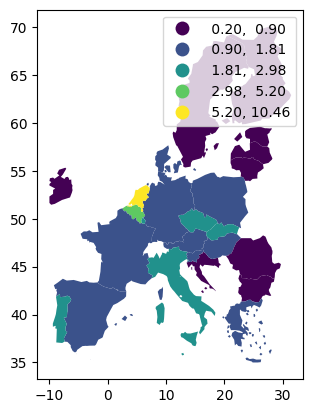

In [48]:
gdfDensitàIndustriale.plot(column="D",scheme="fisher_jenks",k=5,legend=True);

In [49]:
gdfDensitàIndustriale

,I,T,CNTR_ID,geometry,T_STD,Area,D
0,105606.818182,7.232905e+07,AT,"POLYGON ((16.94978 48.53579, 16.85104 48.43864...",-0.374736,84300.491375,1.252743
1,157893.047619,1.157979e+08,BE,"POLYGON ((5.79827 51.05985, 5.76607 51.00859, ...",-0.157570,30365.121427,5.199816
2,69823.272727,5.775631e+07,BG,"POLYGON ((24.32352 43.69769, 24.49383 43.76107...",-0.447539,116408.582534,0.599812
3,215642.045455,1.154959e+08,CZ,"POLYGON ((14.6188 50.8578, 14.82336 50.87055, ...",-0.159079,81019.452902,2.661608
4,545673.272727,8.771563e+08,DE,"MULTIPOLYGON (((9.40281 54.80694, 9.42293 54.8...",3.646091,354078.998336,1.541106
5,59670.045455,9.033952e+07,DK,"MULTIPOLYGON (((15.04086 54.98545, 14.63852 55...",-0.284757,41216.160704,1.447734
6,26378.727273,1.802596e+07,EE,"MULTIPOLYGON (((26.9611 59.43595, 27.17245 59....",-0.646028,46621.318276,0.565808
7,165200.809524,1.000838e+08,EL,"MULTIPOLYGON (((27.83164 35.87551, 27.61189 36...",-0.236076,135861.997674,1.215946
8,596797.590909,3.206590e+08,ES,"MULTIPOLYGON (((4.20006 39.83676, 3.8399 39.92...",0.865893,513240.013860,1.162804
9,71321.147727,5.611255e+07,FI,"MULTIPOLYGON (((28.49493 68.46963, 28.69363 68...",-0.455751,348531.170812,0.204633


In [50]:
gdfDensitàIndustriale['T_KM']=gdfDensitàIndustriale['T']/gdfDensitàIndustriale['Area']

In [51]:
correlazioneD=sp.stats.pearsonr(gdfDensitàIndustriale["D"],gdfDensitàIndustriale["T_KM"])
correlazioneD


PearsonRResult(statistic=0.8767737313818507, pvalue=9.030354130512374e-09)

('WARNING: ', 0.8992603925380674, ' is an island (no neighbors)')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 0.8992603925380674.
  W.__init__(self, neighbors, ids=ids, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/esda/moran.py:1351: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


(<Figure size 640x480 with 1 Axes>, <Axes: >)

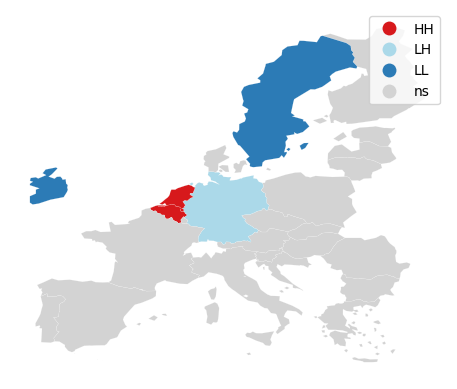

In [52]:
W2=weights.Queen.from_dataframe(gdfDensitàIndustriale, ids="D")
Lisa2=esda.Moran_Local(gdfDensitàIndustriale["D"],W2)
lisa_cluster(Lisa2,gdfDensitàIndustriale)

<Axes: xlabel='T_KM', ylabel='Count'>

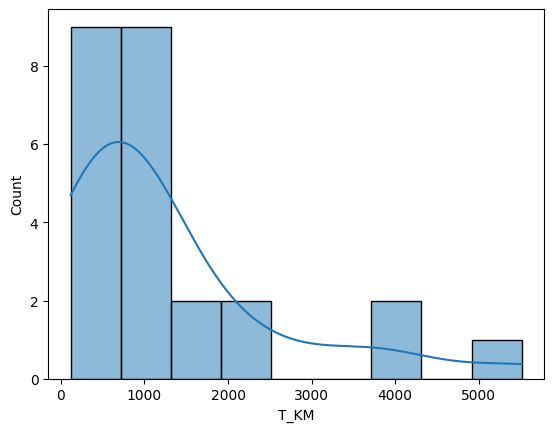

In [53]:
sns.histplot(gdfDensitàIndustriale['T_KM'],kde=True)

<Axes: xlabel='T_KM', ylabel='D'>

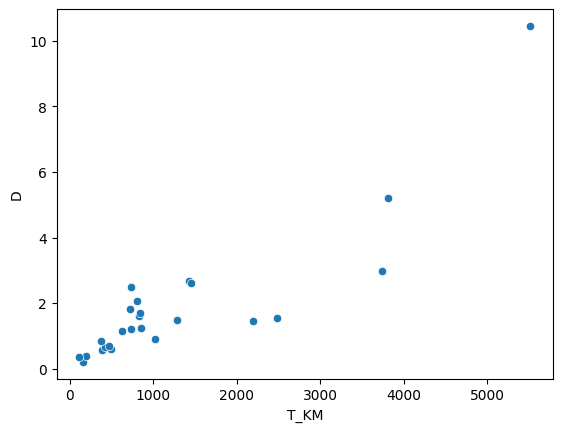

In [54]:
sns.scatterplot(x="T_KM",y="D",data=gdfDensitàIndustriale)

In [55]:
gdfDensitàIndustriale[gdfDensitàIndustriale['T_KM']>5000]

,I,T,CNTR_ID,geometry,T_STD,Area,D,T_KM
18,379297.227273,1.999951e+08,NL,"MULTIPOLYGON (((7.09269 52.8382, 7.00623 52.63...",0.26307,36276.738079,10.45566,5513.040455


In [32]:
Regressione=LinearRegression()
Regressione.fit(gdfDensitàIndustriale[["D"]],gdfDensitàIndustriale["T_KM"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


NameError: name 'Regressione' is not defined

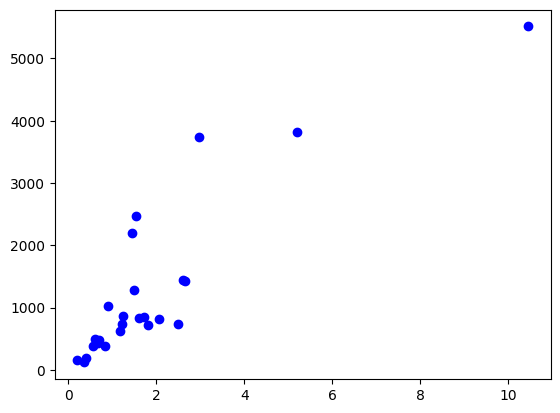

In [56]:
correlazione,p=sp.stats.pearsonr(gdfDensitàIndustriale["D"],gdfDensitàIndustriale["T_KM"])
fig,ax=plt.subplots()
ax.scatter(gdfDensitàIndustriale["D"], gdfDensitàIndustriale["T_KM"], color="blue", label="Dati reali")
ax.plot(gdfDensitàIndustriale["D"], Regressione.predict(gdfDensitàIndustriale[["D"]]), color="red", label="Retta di regressione")
ax.legend()
ax.set_xlabel(r"Industrie per (km$^2$)")
ax.set_ylabel(r"Tonnellate di sostanze inquinanti per (km$^2$)")
ax.text(0.02, 0.98, f"Correlazione (Pearson) = {correlazione:.2f}",
        transform=ax.transAxes, ha="left", va="top",
        bbox=dict(boxstyle="round", fc="white", ec="0.85", alpha=0.9))
plt.savefig("Grafici/Regressione.svg",format="svg")

In [57]:
dfTassePercent=dfTassePercent[dfTassePercent['unit']=='PC_TSCO']
dfTassePercent.drop(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
       'tax', 'Taxes', 'unit', 'Unit of measure', 'geo',
       'Geopolitical entity (reporting)', 'Time','Observation value', 'OBS_FLAG',
       'Observation status (Flag) V2 structure', 'CONF_STATUS',
       'Confidentiality status (flag)'],axis=1,inplace=True)

In [58]:
dfTassePercent=dfTassePercent.rename(columns={"OBS_VALUE":"PERC_TASSE"})

In [59]:
dfEmissioniEuropa.drop(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
       'unit', 'Unit of measure', 'airpol',
       'Air pollutants and greenhouse gases', 'src_nfr',
       'Source sectors for emissions of air pollutants (Nomenclature for reporting, CLRTAP)',
       'geo', 'Geopolitical entity (reporting)','Time','Observation value', 'OBS_FLAG',
       'Observation status (Flag) V2 structure', 'CONF_STATUS',
       'Confidentiality status (flag)'],axis=1,inplace=True)

In [60]:
dfEmissioniEuropa=dfEmissioniEuropa.groupby('TIME_PERIOD').aggregate({"OBS_VALUE":"sum"})
dfEmissioniEuropa=dfEmissioniEuropa.rename(columns={"OBS_VALUE":"EmissioniAnno"})

In [61]:
dfTempo=dfEmissioniEuropa.merge(dfTassePercent, on="TIME_PERIOD")

In [62]:
dfTempo

,TIME_PERIOD,EmissioniAnno,PERC_TASSE
0,1995,301776303,6.36
1,1996,297767397,6.42
2,1997,284545253,6.30
3,1998,269624513,6.35
4,1999,253978420,6.43
5,2000,239205731,6.28
6,2001,229623507,6.40
7,2002,221849851,6.50
8,2003,218285324,6.62
9,2004,210479853,6.64


<Axes: xlabel='TIME_PERIOD', ylabel='PERC_TASSE'>

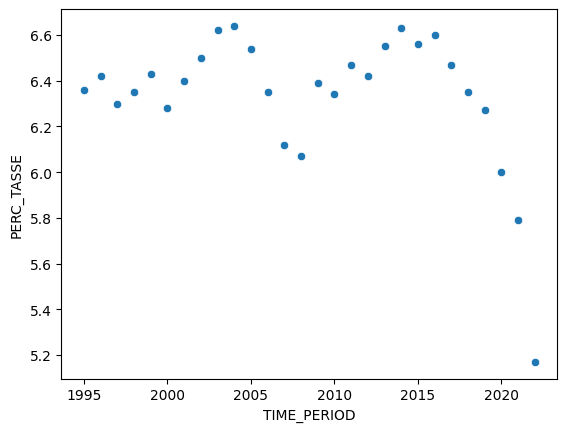

In [63]:
sns.scatterplot(x=dfTempo['TIME_PERIOD'],y=dfTempo["PERC_TASSE"])

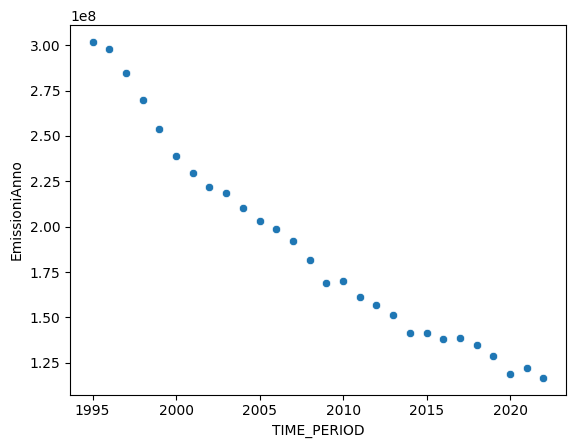

In [64]:
sns.scatterplot(x=dfTempo['TIME_PERIOD'],y=dfTempo["EmissioniAnno"])
dfTempo.to_pickle("EmissioniTempoT.pickle")

In [65]:
dfPilProCap=dfPilProCap.set_index('TIME_PERIOD')

In [66]:
dfPilProCap=dfPilProCap.groupby('geo','TIME_PERIOD').aggregate({"OBS_VALUE":"mean"})

ValueError: No axis named TIME_PERIOD for object type DataFrame

In [67]:
dfPilProCap

,DATAFLOW,LAST UPDATE,freq,unit,na_item,geo,OBS_VALUE,OBS_FLAG,CONF_STATUS
TIME_PERIOD,,,,,,,,,
2000,ESTAT:SDG_08_10(1.0),26/08/25 23:00:00,A,CLV20_EUR_HAB,B1GQ,AL,2120.0,NaN,NaN
2001,ESTAT:SDG_08_10(1.0),26/08/25 23:00:00,A,CLV20_EUR_HAB,B1GQ,AL,2330.0,NaN,NaN
2002,ESTAT:SDG_08_10(1.0),26/08/25 23:00:00,A,CLV20_EUR_HAB,B1GQ,AL,2440.0,NaN,NaN
2003,ESTAT:SDG_08_10(1.0),26/08/25 23:00:00,A,CLV20_EUR_HAB,B1GQ,AL,2580.0,NaN,NaN
2004,ESTAT:SDG_08_10(1.0),26/08/25 23:00:00,A,CLV20_EUR_HAB,B1GQ,AL,2730.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2015,ESTAT:SDG_08_10(1.0),26/08/25 23:00:00,A,CLV_PCH_PRE_HAB,B1GQ,UK,1.6,NaN,NaN
2016,ESTAT:SDG_08_10(1.0),26/08/25 23:00:00,A,CLV_PCH_PRE_HAB,B1GQ,UK,0.9,NaN,NaN
2017,ESTAT:SDG_08_10(1.0),26/08/25 23:00:00,A,CLV_PCH_PRE_HAB,B1GQ,UK,1.1,NaN,NaN


In [68]:
gdfDensitàIndustriale.to_pickle("Dataset/Densità.pickle")